In [11]:
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path: sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
import imgaug
from imgaug import augmenters as iaa

class TrainImgAugTransform:
    """
    Dont crop: not every cell has perfect data, some lose some class if you crop it
    You can mess up with location info: they are not that important
    Dont twist too much green data: their structure is important
    You can think of this challenge as
    Add Negative Sample: no green layer should have no sample
    Wrap is bad
    Green layer's Sharpon should be carefully designed. It should adjust with other paremeters.
    Dropout need to tested by network
    iaa.ContrastNormalization((x, x)) Will change background and amount of green. be careful.

    """
    def __init__(self, zoom=256, interpolation=['nearest', 'linear', 'area', 'cubic']):
        self.aug = iaa.Sequential([
            iaa.CropAndPad(percent=(0, 0.1), pad_mode=["constant", "reflect"], pad_cval=0),
            iaa.OneOf([
                iaa.Noop(),
                iaa.PiecewiseAffine(scale=(0.00, 0.02), nb_rows=4, nb_cols=4, mode=["constant", "reflect", "wrap"], cval=0),
                iaa.Affine(rotate=(-10, 10), mode=["constant", "reflect"], cval=0),
                iaa.Affine(shear=(-10, 10), mode=["constant", "reflect"], cval=0),
            ]),
            iaa.PiecewiseAffine(scale=(0.00, 0.05), nb_rows=4, nb_cols=4, mode=["constant", "reflect", "wrap"], cval=0),
            iaa.ContrastNormalization((1.0, 1.01)),
            iaa.Scale({"height": zoom, "width": zoom}, interpolation=interpolation),
            iaa.WithChannels([0,2,3], iaa.Sequential([
                iaa.OneOf([
                    iaa.Noop(),
                    iaa.EdgeDetect(alpha=(0.0, 0.1)),
                    iaa.Multiply((0.8, 1.3), per_channel=1.0),
                    iaa.ContrastNormalization((0.95, 1.05))
                ]),
                iaa.OneOf(
                    iaa.CoarseDropout((0.0, 0.02), size_percent=(0.005, 0.005), per_channel=1.0),
                ),
                iaa.Sharpen(alpha=(0.0, 0.25), lightness=(0.0, 0.45)),
                ])),
            iaa.WithChannels([1], iaa.Sequential([
                iaa.OneOf([
                    iaa.Noop(),
                    iaa.Multiply((1.0, 1.15)),
                    iaa.ContrastNormalization((1.0, 1.01)),
                ]),
                iaa.Sharpen(alpha=(0.24, 0.26), lightness=(0.44, 0.46)),
            ])),
#             iaa.Fliplr(0.5),
#             iaa.Flipud(0.5),

        ], random_order=False)

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

    def to_deterministic(self, n=None):
        self.aug = self.aug.to_deterministic(n)
        return self

class AggressiveTrainImgAugTransform:
    """
    Dont crop: not every cell has perfect data, some lose some class if you crop it
    You can mess up with location info: they are not that important
    Dont twist too much green data: their structure is important
    You can think of this challenge as
    Add Negative Sample: no green layer should have no sample
    Wrap is bad
    Green layer's Sharpon should be carefully designed. It should adjust with other paremeters.
    Dropout need to tested by network
    iaa.ContrastNormalization((x, x)) Will change background and amount of green. be careful.

    """
    def __init__(self, zoom=256, interpolation=['nearest', 'linear', 'area', 'cubic']):
        self.aug = iaa.Sequential([
            iaa.CropAndPad(percent=(0, 0.1), pad_mode=["constant", "reflect"], pad_cval=0),
            iaa.OneOf([
                iaa.Noop(),
                iaa.PiecewiseAffine(scale=(0.00, 0.02), nb_rows=4, nb_cols=4, mode=["constant", "reflect", "wrap"], cval=0),
                iaa.Affine(rotate=(-10, 10), mode=["constant", "reflect"], cval=0),
                iaa.Affine(shear=(-10, 10), mode=["constant", "reflect"], cval=0),
            ]),
            iaa.PiecewiseAffine(scale=(0.00, 0.05), nb_rows=4, nb_cols=4, mode=["constant", "reflect", "wrap"], cval=0),
            iaa.ContrastNormalization((1.0, 1.01)),
            iaa.Scale({"height": zoom, "width": zoom}, interpolation=interpolation),
            iaa.WithChannels([0,2,3], iaa.Sequential([
                iaa.OneOf([
                    iaa.Noop(),
                    iaa.EdgeDetect(alpha=(0.0, 0.1)),
                    iaa.Multiply((0.2, 1.3), per_channel=1.0),
                    iaa.ContrastNormalization((0.95, 1.05))
                ]),
                iaa.OneOf(
                    iaa.CoarseDropout((0.0, 0.02), size_percent=(0.005, 0.005), per_channel=1.0),
                ),
                iaa.Sharpen(alpha=(0.0, 0.25), lightness=(0.0, 0.45)),
                ])),
            iaa.WithChannels([1], iaa.Sequential([
                iaa.OneOf([
                    iaa.Noop(),
                    iaa.Multiply((1.0, 1.15)),
                    iaa.ContrastNormalization((1.0, 1.01)),
                ]),
                iaa.Sharpen(alpha=(0.24, 0.26), lightness=(0.44, 0.46)),
            ])),
#             iaa.Fliplr(0.5),
#             iaa.Flipud(0.5),

        ], random_order=False)

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

    def to_deterministic(self, n=None):
        self.aug = self.aug.to_deterministic(n)
        return self

In [12]:
import numpy as np
import os

load_img_dir = "/media/koke_cacao/68181BB6539B22A4/data"
file = list(set([x.replace(".png", "").replace("_red", "").replace("_green", "").replace("_blue", "").replace("_yellow", "") for x in os.listdir(load_img_dir)]))
def get_load_image_by_id(id, dir):
    """

    :param indice: id
    :return: nparray image of (r, g, b, y) from 0~255 (['red', 'green', 'blue', 'yellow']) (4, W, H)
    """

    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    imgs = [cv2.imread(os.path.join(dir, id + '_' + color + ".png"), flags).astype(np.uint8) for color in colors]
    return np.stack(imgs, axis=-1)

name_label_dict = {
        0: 'Nucleoplasm',
        1: 'Nuclear membrane',
        2: 'Nucleoli',
        3: 'Nucleoli fibrillar center',
        4: 'Nuclear speckles',
        5: 'Nuclear bodies',
        6: 'Endoplasmic reticulum',
        7: 'Golgi apparatus',
        8: 'Peroxisomes',
        9: 'Endosomes',
        10: 'Lysosomes',
        11: 'Intermediate filaments',
        12: 'Actin filaments',
        13: 'Focal adhesion sites',
        14: 'Microtubules',
        15: 'Microtubule ends',
        16: 'Cytokinetic bridge',
        17: 'Mitotic spindle',
        18: 'Microtubule organizing center',
        19: 'Centrosome',
        20: 'Lipid droplets',
        21: 'Plasma membrane',
        22: 'Cell junctions',
        23: 'Mitochondria',
        24: 'Aggresome',
        25: 'Cytosol',
        26: 'Cytoplasmic bodies',
        27: 'Rods & rings'}

<IPython.core.display.Javascript object>


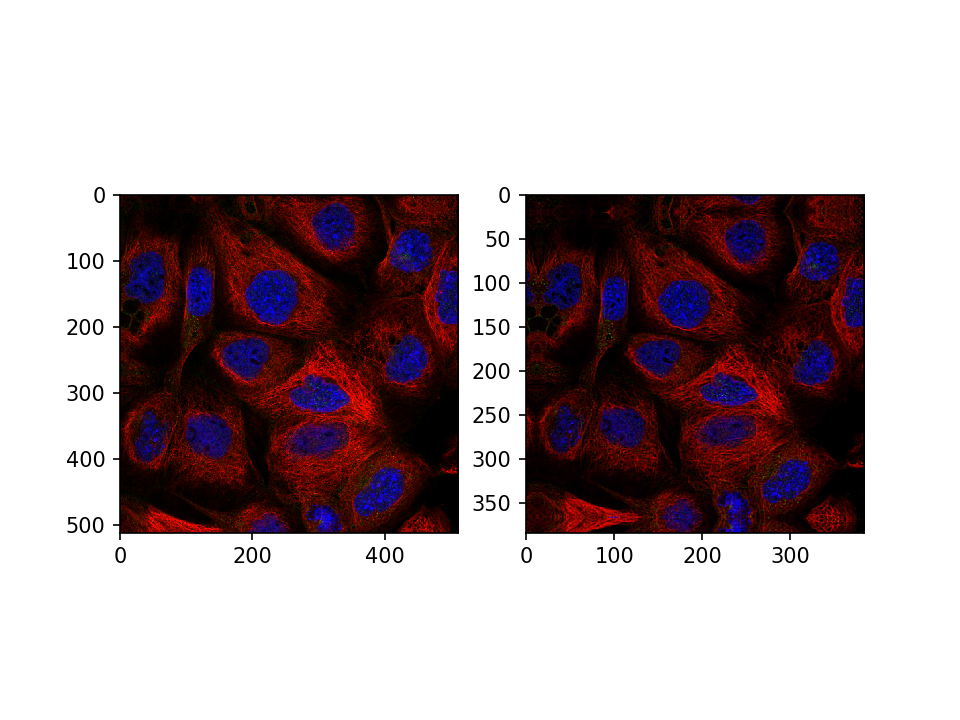

(512, 512, 4)
File:0b67a000-bb9c-11e8-b2b9-ac1f6b6435d0, Index:134, Label:['Microtubule organizing center'], Id:[18]


In [23]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from random import randint
import pandas as pd

rad = randint(0, 200)
index = rad

# 35: lack of green. Should I adjust so it would be better than original image? (I increase intensity) iaa.Sharpen(alpha=(0.25, 0.25), lightness=(0.45, 0.45)),
# 42: wrong label? trying to adjust green intensity you will see different image
# 17: check 17 to see if you need more green sharpen iaa.Sharpen(alpha=(0.5, 0.5), lightness=(0.1, 0.1)),
# 8: check 8 to see if you need less green sharpen iaa.Sharpen(alpha=(0.2, 0.2), lightness=(0.2, 0.2)),
# 65: check 65 to see if you need more green intensity
# 59:158
# 180: blury
# 103: what a strange image 0a022f5e-bbca-11e8-b2bc-ac1f6b6435d0
# 116: biggest aug cell light
# 152: seems nothing
# 120: bad edge ditect if too much
# 41: only green? Cytosol? What is that? It should always appear if Nucleoplasm appears, right? 0c1d7284-bbc1-11e8-b2bb-ac1f6b6435d0

img = get_load_image_by_id(file[index], load_img_dir)

dataframe = pd.read_csv("/home/koke_cacao/Downloads/train.csv", engine='python').set_index('Id')
labelframe = list(list(int(i) for i in s.split()) for s in dataframe['Target'])

def np_three_channel_with_green(image, shape, green_intensity=1, other_intensity=1):
    """

    :param tensor: tensor with channel of (r, g, b, y), shape of (4, W, H)
    :return: drop tensor[1], the output will put the cannel layer the last layer
    """
    image = image.transpose((2, 0, 1))
    img = np.zeros(shape)
    img[0] = other_intensity*(0.5*image[0] + 0.25*image[3])/0.75
    img[1] = (green_intensity*0.5*image[1] + 0*image[3])/0.75
    img[2] = other_intensity*image[2]
    return np.stack(img/255., axis=-1)
def np_three_channel_without_green(image, shape, green_intensity=0):
    """

    :param tensor: tensor with channel of (r, g, b, y), shape of (4, W, H)
    :return: drop tensor[1], the output will put the cannel layer the last layer
    """
    image = image.transpose((2, 0, 1))
    img = np.zeros(shape)
    img[0] = (0.5*image[0] + 0.25*image[3])/0.75
    img[1] = (green_intensity*0.5*image[1] + 0.25*image[3])/0.75
    img[2] = image[2]
    return np.stack(img/255., axis=-1)

%matplotlib notebook
# plt.subplot(221)
# plt.imshow(img, vmin=0, vmax=1)
plt.subplot(121)
plt.imshow(np_three_channel_with_green(img, (3, 512, 512)), vmin=0, vmax=1)
plt.show()

# ['nearest', 'linear', 'area', 'cubic']
# z = 512 #4*4*4*4*2
# z = 224 #4*4*2*7
# z = 288 #4*4*2*9
z = 384 #4*4*2*12
print(img.shape)
img_t = TrainImgAugTransform(zoom=z, interpolation='ALL').to_deterministic()(img)
# plt.subplot(223)
# plt.imshow(img, vmin=0, vmax=1)
plt.subplot(122)
plt.imshow(np_three_channel_with_green(img_t, (3, z, z)), vmin=0, vmax=1)

# plt.subplot(133)
# plt.imshow(np_three_channel_without_green(img, (3, 512, 512)), vmin=0, vmax=1)
# plt.show()

gen = list(list(int(i) for i in s.split()) for s in dataframe.loc[file[index]])[0]
gen2 = [name_label_dict[j] for j in gen]
print("File:{}, Index:{}, Label:{}, Id:{}".format(file[index], index, gen2, gen))